# OAM computations for Linear field using SFA

This jupyter notebook is to compute the OAM of a linear field SFA model with a sin$^2$ pulse.
Andrew Maxwell 11/05/2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import functools
import time
from itertools import repeat
from itertools import product

mpl.rcParams['savefig.pad_inches'] = 0

In [2]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
    
pool = multiprocessing.Pool(processes=cpus)

In [3]:
Pi = np.pi
I = complex(0.,1.)

### Dump File and Pickling

currently this is how Data may be outputted, as a pickle file, we may want to change this to JSON? However, pickle files are very compact.

In [4]:
import pickle
import os
DumpFileName = 'OAM_Lin_DataDump'

In [5]:
def saveDataDump(DataKey, Data, DumpFileName):
    '''Function saves data to file via pickling for easy access and loading'''
    Dics={"Null" : 0}
    #load full database
    if(os.path.exists(DumpFileName)):
        with open(DumpFileName,'rb') as rfp:
            Dics.update(pickle.load(rfp))
            
    #Make new dictionary of data
    OutputDataDict={DataKey : Data}
    #Append new dicitonary to all dictionarys
    Dics.update(OutputDataDict)
    #open file and dump all dicitionarys
    DataDumpFile = open(DumpFileName,'wb')
    pickle.dump(Dics, DataDumpFile)
    DataDumpFile.close()

In [6]:
def loadDataDump(DataKey, DumpFileName):
    '''Function to retrieve data from pickle dump'''
    DataDumpFile = open(DumpFileName,'rb')
    DataOut = pickle.load(DataDumpFile)[DataKey]
    DataDumpFile.close()
    return DataOut

## Import SFA Circi Pulse

Here we lad the class that compute the SFA transition amplitude.
It has three class varibles Ip, Up and omega

In [7]:
import SFALinearPulse as SFA_Lin

### Test SFA Class

In [8]:
#Make class instance
omegaIn = 0.057
IpIn = 0.5
UpIn = 0.44
NIn = 5
CEPIn = 0.
ts = Pi/omegaIn + I* Pi/(2*omegaIn)
#make SFA pulse instance
SP = SFA_Lin.SFALinearPulse(IpIn, UpIn, omegaIn, NIn, CEPIn)

In [9]:
ps =1.
thetas = Pi/3
phis=0.
Zs = 1+I
#print(np.polynomial.polynomial.polyroots(SP.DSZ(ps, thetas, phis)))
#print(SP.DSZ_val(ps, thetas, phis,Zs))
print(SP.Af2I(ts))
print(SP.S(ps, thetas, phis, ts))
#print(SP.DDS(ps, thetas, phis, ts))
#times = SP.TimesGen(ps, thetas, phis)#, 4*Pi/omegaIn + I* Pi/(2*omegaIn))
#errs=np.array([SP.DS(ps, thetas, phis, ti) for ti in times])
#print(np.array(times))
#print(np.abs(errs)**2)

(-1.0320217708542714+0.3180683655176057j)
(55.34110479002985+25.38650930373545j)


### Create list of pulse and target parameters

In [10]:
Ns = np.array([3, 4, 5])
CEPs = np.array([0., Pi/2, 0.])
Ups = np.array([0.22, 0.22, 0.22])
Ips = np.array([0.579, 0.579, 0.579])
TargetList =np.array([3, 3, 3]) # currently 3=Ar and 0=He, can make more user friendly selction in future
SPs = np.array([SFA_Lin.SFALinearPulse(Ipi, Upi, omegaIn, Ni, CEPi, Targi) for Ipi, Upi, Ni, CEPi, Targi in zip(Ips, Ups, Ns, CEPs, TargetList)])
NPulses = len(SPs)

### Plot Times and Efield

In [11]:
tSample = np.linspace(0., Ns[-1]*2*Pi/omegaIn, 2000)
EfList = [[SPs[i].Ef(t) for t in tSample]
        for i in range(0, NPulses)]

In [12]:
pList = np.linspace(-2, 2, 250)
pIndx = 150
tList = [
    np.array([np.sort(SPs[i].TimesGen(p, thetas, phis)) for p in pList])
    for i in range(0, NPulses)]
       

E1Points = np.array([
    [SPs[i].Ef(tn.real) 
      #abs(ten.real) < tauEnd(Ns[i]) else None 
     for tn in tList[i][pIndx]]
    for i in range(0, NPulses)], dtype=object)

#swap dimension tlist
tList= np.array([np.transpose(tListi) 
        for tListi in tList],dtype=object)

Mins =[[pList[np.argmin(np.imag(tp))] for tp in tList[i] ] for i in range(0, NPulses)]

In [13]:
saveDataDump('TimesPlot', [NPulses, tSample, EfList, pList, tList,E1Points,pIndx], DumpFileName)

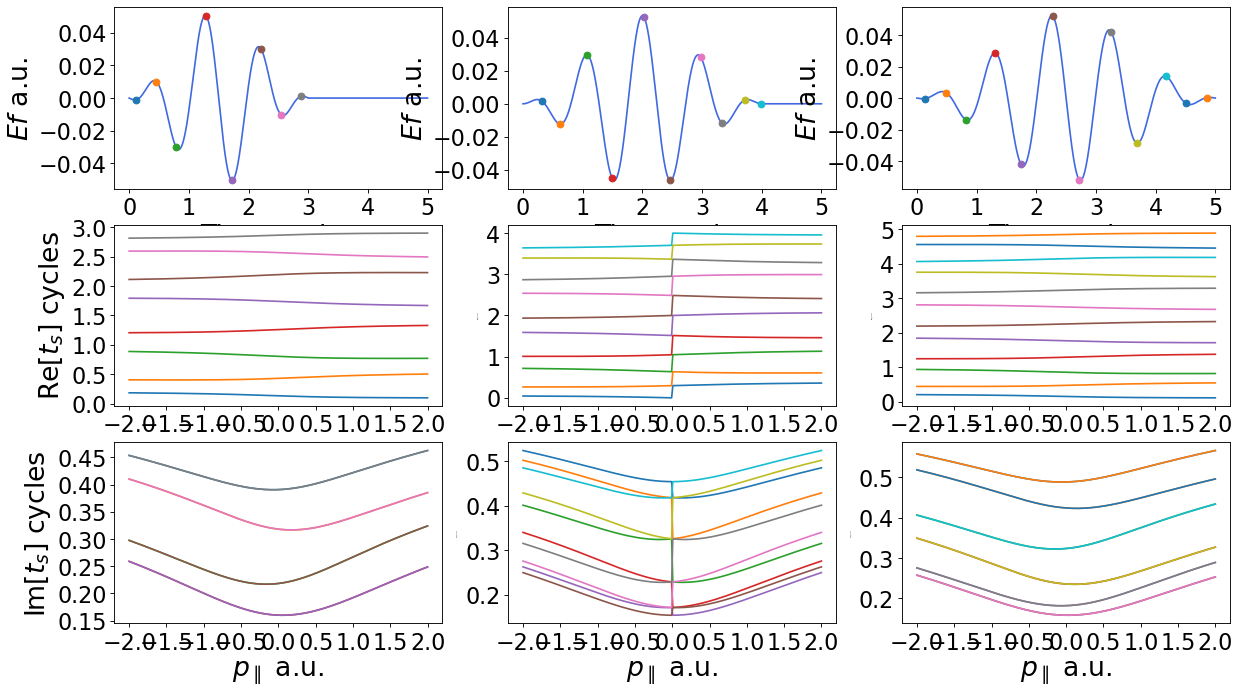

In [14]:
[NPulses, tSample, EfList, pList, tList,E1Points,pIndx] = loadDataDump('TimesPlot', DumpFileName)
plt.style.use('default')
plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(0, NPulses):
    #on E field plot
    ax = plt.subplot(3, NPulses, i+1)
    plt.xlabel('Time cycles', fontsize=24)
    plt.ylabel('$Ef$ a.u.', fontsize= 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().set_prop_cycle(None)
    plt.plot(tSample* omegaIn/(2*Pi), EfList[i], '-',label='Ef',color='royalblue')
    #plt.plot(tList[i][:,-1].real, E1Pointsx,'o')
    for j in range(0,len(tList[i])):
        #plt.axvline(x=tList[i][j][pIndx].real* omegaIn/(2*Pi), color='black',linestyle='-.')
        plt.plot(tList[i][j][pIndx].real* omegaIn/(2*Pi), E1Points[i][j],'o')
    
    #real time plot
    ax = plt.subplot(3, NPulses, NPulses+i+1)
    #ax.text(0.025, 0.95, panelLabels[1][i], transform=ax.transAxes,
     # fontsize=28, fontweight='bold', va='top')
    plt.ylabel('$\mathrm{Re}[{t_s}]$ cycles', fontsize=24 if i==0 else 0)
    plt.xlabel('$p_{\parallel}$ a.u.', fontsize= 24 )
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().set_prop_cycle(None)
    #plt.ylim(0.15,0.7)
    
    tLen = len(tList[i])
    for j in range(0,tLen):
        plt.plot(pList,np.array(tList[i][j]).real * omegaIn/(2*Pi),'-')
        #tend = tList[i][j][-1]* omegaIn/(2*Pi)
        #plt.text(2.4, tend.imag, "{0:.1f}".format(tend.real),fontsize=(14))
    plt.gca().set_prop_cycle(None)
    
    #imginary time plot
    ax = plt.subplot(3, NPulses, 2*NPulses+i+1)
    #ax.text(0.025, 0.95, panelLabels[1][i], transform=ax.transAxes,
     # fontsize=28, fontweight='bold', va='top')
    plt.ylabel('$\mathrm{Im}[{t_s}]$ cycles', fontsize=24 if i==0 else 0)
    plt.xlabel('$p_{\parallel}$ a.u.', fontsize= 24 )
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.gca().set_prop_cycle(None)
    #plt.ylim(0.15,0.7)
    
    tLen = len(tList[i])
    for j in range(0,tLen):
        plt.plot(pList,np.array(tList[i][j]).imag * omegaIn/(2*Pi),'-')
        #tend = tList[i][j][-1]* omegaIn/(2*Pi)
        #plt.text(2.4, tend.imag, "{0:.1f}".format(tend.real),fontsize=(14))
    plt.gca().set_prop_cycle(None)

## Compute Momentum Distribusions

In [15]:
dp = 4./250
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1.7, dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)
py = 0.1

Here we compute the transition amplitudes from scratch and print the computational time required for all pulses in total

In [16]:
t1 = time.time()
MGrids = [ np.array(pool.starmap(SPs[i].Mxz_List, zip(pxGrid, repeat(py),  pzGrid) ))
          for i in range(0, NPulses)]
t2 = time.time()
print(t2 - t1)

3.657097339630127


In [17]:
MGrids = [np.abs(MGrids[i])**2 for i in range(0, NPulses)]
MMaxs = [np.max(MGrids[i]) for i in range(0, NPulses)]

#### Pickle and Dump

In [18]:
saveDataDump('MomentumPlot', [NPulses, pzList, pxList, MGrids, MMaxs], DumpFileName)

<Figure size 640x480 with 0 Axes>

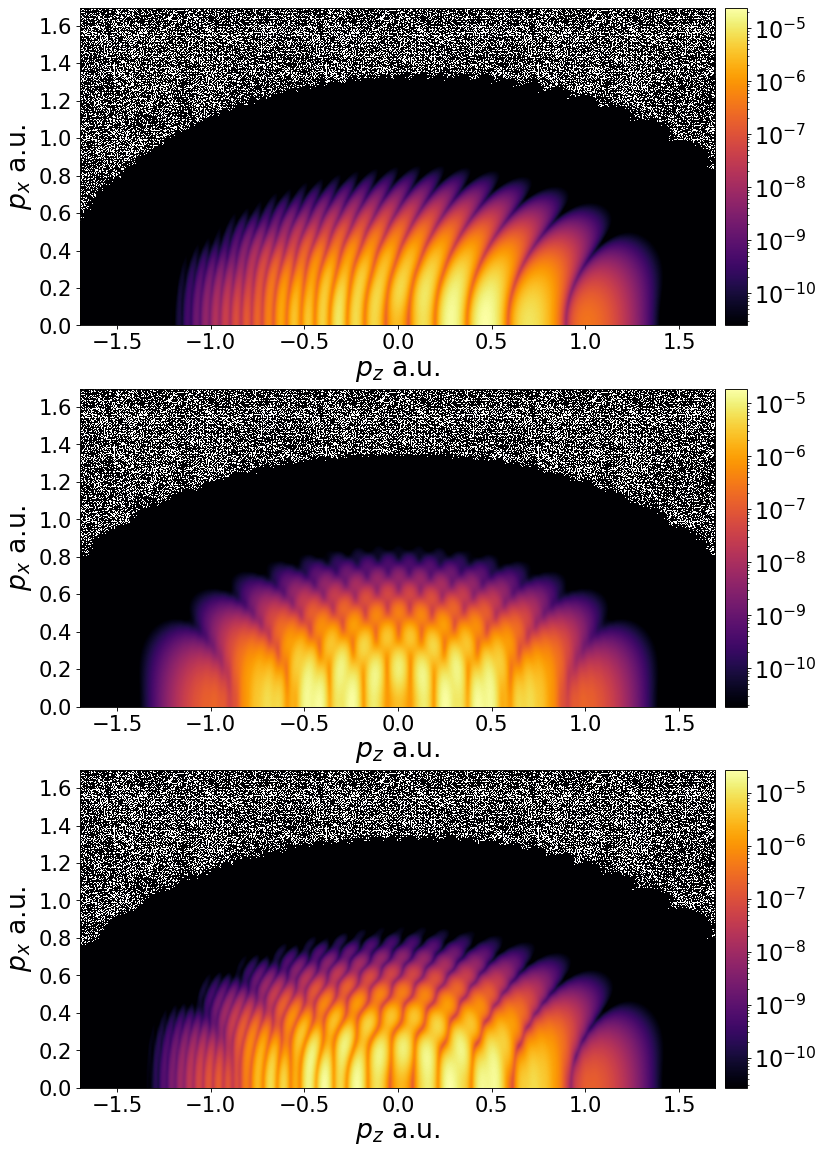

In [19]:
[NPulses, pzList, pxList, MGrids, MMaxs] = loadDataDump('MomentumPlot', DumpFileName)

plt.style.use('default')
dcolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.tight_layout()
#plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)

panelLabels = [['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)'], ['(h)', '(i)', '(j)']]
Titles = [str(Ns[i])+'-Cycle'for i in range(0,3)]

plt.figure(num=None, figsize=(14, 5*NPulses), dpi=80, facecolor='w', edgecolor='k')
plt.autoscale(tight=True)
for i in range(0, NPulses):
    ax = plt.subplot(NPulses, 1, i+1)
#     ax.text(0.025, 0.95, panelLabels[2][i], transform=ax.transAxes,
#       fontsize=40, fontweight='bold', va='top', color ='white')
    plt.ylabel('$p_{x}$ a.u.', fontsize=(24))
    plt.xlabel('$p_{z}$ a.u.', fontsize=(24))
    plt.xticks(fontsize=(19))
    plt.yticks(fontsize=(19))
    
    #ax = plt.gca()
    im = ax.imshow(np.flip(MGrids[i],0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
              cmap=cm.inferno, norm=LogNorm(vmin=MMaxs[i]*1e-6, vmax=MMaxs[i]), 
                interpolation = 'bicubic', aspect = 1.)

    
    aspect = 15
    pad_fraction = 0.5
    divider = make_axes_locatable(ax)
    width = axes_size.AxesY(ax, aspect=1./aspect)
    pad = axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=20)

#plt.margins(0.1,0.1)
plt.subplots_adjust(top = 0.975, bottom = 0.075, right = 0.925, left = 0.1, hspace = 0.2, wspace = 0.05)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/Pulse_FieldTimesMom.pdf")

## Spectra Tests

In [20]:
ELim = 1.
dE = ELim/250
EList = np.arange(0, ELim, dE)

Here we compute the spectra from scratch  and print the computational time over all pulses in total

In [21]:
t1 = time.time()
SpectraList = [pool.starmap(SPs[i].Spectra, zip(EList, repeat(0.), repeat(np.inf) , repeat(1.0e-02) ))
               for i in range(0,NPulses)]
t2 = time.time()
print(t2 - t1)

2.3894026279449463


In [22]:
saveDataDump('SpectraPlot', [NPulses, EList, SpectraList], DumpFileName)

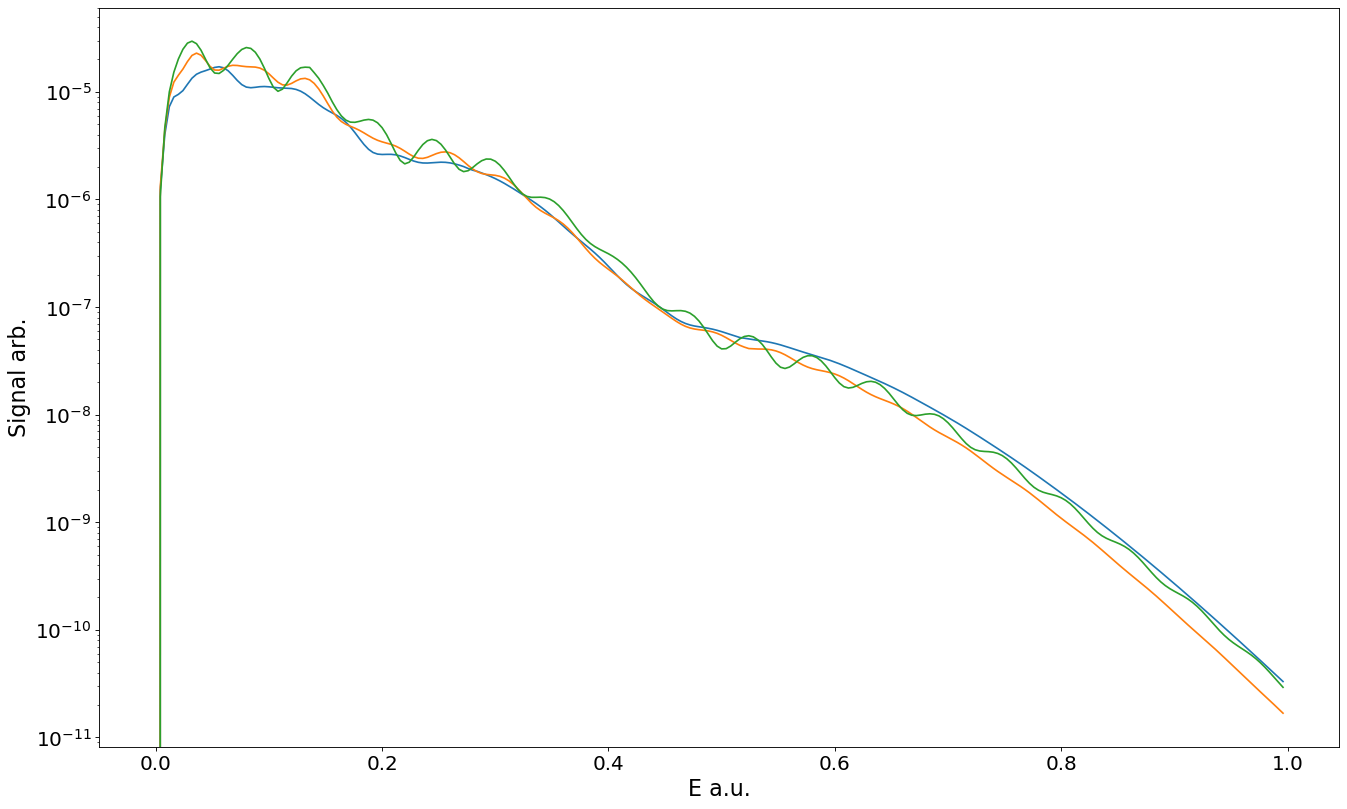

In [23]:
[NPulses, EList, SpectraList] = loadDataDump('SpectraPlot', DumpFileName)
plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Signal arb.', fontsize=20)
plt.xlabel('E a.u.', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale("log")
#plt.xlim(0.01, 1.75)
#plt.ylim(1e-6, 1e2)
for Spec in SpectraList:
    plt.plot(EList,Spec,'-')

# OAM Plots

In [24]:
OAM_N = 9
lList = np.array([OAM_N-1, 0, 1])
dp = 4./150
pzList = np.arange(-1.7, 1.7, dp)
pxList = np.arange(0, 1.7, dp)
pzGrid, pxGrid = np.meshgrid(pzList, pxList)

In [25]:
t1 = time.time()
MlGrids = [ np.array(pool.starmap(SPs[i].Mlxz_List, zip(pxGrid,  pzGrid, repeat(OAM_N)) )).T
          for i in range(0, NPulses)]
t2 = time.time()
print(t2 - t1)

10.950695276260376


In [26]:
saveDataDump('OAMPlots', [pzList, pxList, lList, MlGrids], DumpFileName)

In [27]:
MlMaxIndex = np.array([[np.max(M) for M in Ml] for Ml in MlGrids])

In [28]:
def lLabel(l):
    if(l<OAM_N/2.):
        return str(l)
    else:
        return str(l-OAM_N)

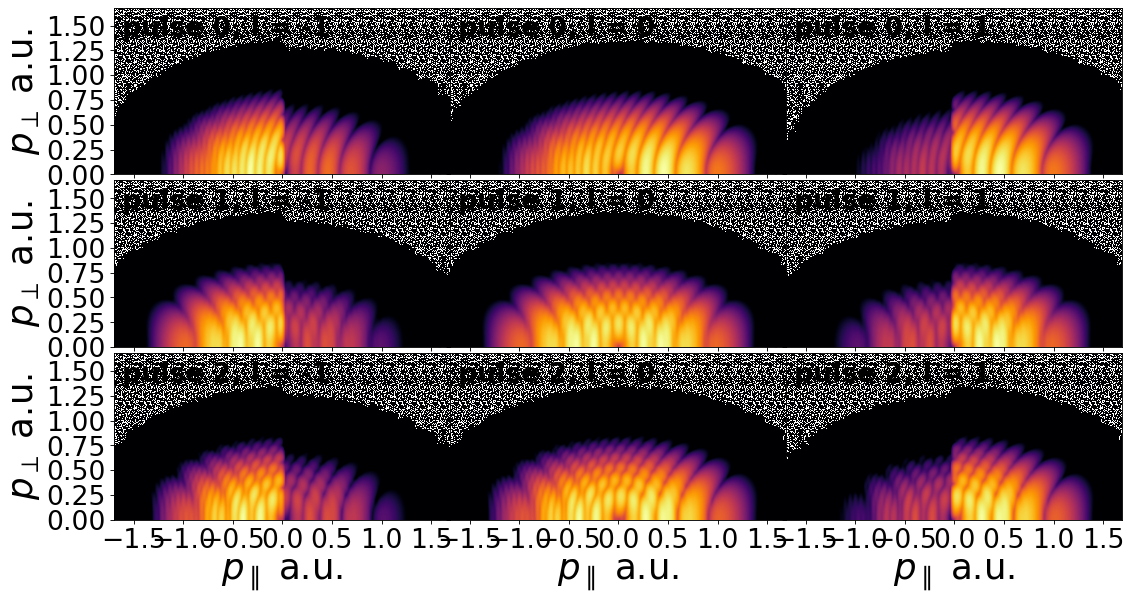

In [29]:
[pzList, pxList, lList, MlGrids] = loadDataDump('OAMPlots', DumpFileName)

plt.figure(num=None, figsize=(18, 7), dpi=80, facecolor='w', edgecolor='k')
plt.tight_layout()
plt.autoscale(tight=True)
for j in range(0,3):
    for il in range(0, len(lList)):
        l = lList[il]
        ax = plt.subplot(3, len(lList), len(lList)*j + il+1)
        plt.ylabel('$p_{\perp}$ a.u.', fontsize=(32 if il==0 else 0))
        plt.xlabel('$p_{\parallel}$ a.u.', fontsize=(32 if j==2 else 0))
        plt.xticks(fontsize=(24 if j==2 else 0))
        plt.yticks(fontsize=(24 if il==0 else 0))
        
        ax.text(0.025, 0.95, 'pulse '+str(j)+', l = '+lLabel(l), transform=ax.transAxes,
      fontsize=24, fontweight='bold', va='top')
    
        im = ax.imshow(np.flip(MlGrids[j][l].T,0), extent = (np.amin(pzList), np.amax(pzList), np.amin(pxList), np.amax(pxList)),
              cmap=cm.inferno, norm=LogNorm(vmin=MlMaxIndex[j][l]*1e-6, vmax=MlMaxIndex[j][l]), 
                interpolation = 'bicubic', aspect = 1.)
        #ax.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0.075, right = 0.85, left = 0.15, 
            hspace = 0, wspace = 0)
#plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("/home/asmaxwell/Dropbox/Documents/2020_PostDoc_ICFO/AnalyticalOAM/Figures/OAMPulseDistribusions_Even.pdf")